* #### Importando pacotes

In [ ]:
library(dplyr)
library(magrittr)
library(electionsBR)
library(fuzzyjoin)
library(ggplot2)
library(extrafont)
library(stringi)

In [3]:
informacao_16 = read.csv("informacao_2016.csv")

informacao_20 = read.csv("informacao_2020.csv")

* #### Configurações de tela

In [4]:
options(scipen = 999)
windowsFonts(Times = windowsFont("TT Times New Roman"))
options(OutDec =  ",")
options(digits = 3)

#### Importando as informações de **2016**

In [ ]:
informacao_16 <- candidate_local(2016)

* #### Descrição da base

In [6]:
glimpse(informacao_16)

Rows: 498.340
Columns: 63
$ DT_GERACAO                    <chr> "18/02/2021", "18/02/2021", "18/02/2021"~
$ HH_GERACAO                    <time> 12:07:20, 12:07:20, 12:07:20, 12:07:20,~
$ ANO_ELEICAO                   <dbl> 2016, 2016, 2016, 2016, 2016, 2016, 2016~
$ CD_TIPO_ELEICAO               <dbl> 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2~
$ NM_TIPO_ELEICAO               <chr> "ELEIÇÃO ORDINÁRIA", "ELEIÇÃO ORDINÁRIA"~
$ NR_TURNO                      <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1~
$ CD_ELEICAO                    <dbl> 220, 220, 220, 220, 220, 220, 220, 220, ~
$ DS_ELEICAO                    <chr> "Eleições Municipais 2016", "Eleições Mu~
$ DT_ELEICAO                    <chr> "02/10/2016", "02/10/2016", "02/10/2016"~
$ TP_ABRANGENCIA                <chr> "MUNICIPAL", "MUNICIPAL", "MUNICIPAL", "~
$ SG_UF                         <chr> "AC", "AC", "AC", "AC", "AC", "AC", "AC"~
$ SG_UE                         <chr> "01112", "01511", "01570", "01538", "010~
$ NM_UE       

* #### Selecionando variáveis e filtrando informações 

In [5]:
# Eleitos no 1º turno
turno_1 = informacao_16 %>%
  filter(DS_CARGO == "PREFEITO" & CD_TIPO_ELEICAO == 2 & NR_TURNO == 1 &
           DS_SIT_TOT_TURNO == "ELEITO") %>%
  select(SG_UE, NM_UE, NM_CANDIDATO, DT_ELEICAO)

  #Eleitos no 2º turno
turno_2 = informacao_16 %>%
  filter(DS_CARGO == "PREFEITO" & CD_TIPO_ELEICAO == 2 & NR_TURNO == 2 &
           DS_SIT_TOT_TURNO == "ELEITO") %>%
  select(SG_UE, NM_UE, NM_CANDIDATO, DT_ELEICAO)

  #União dos dois turnos
inf_16  = rbind(turno_1, turno_2)

Tendo em vista que pode ter prefeitos eleitos em 2016 que foram cassados ou deixaram o cargo, irei filtrar as eleições suplementares e considerar os candidatos eleitos nessas eleições. Isto é, caso tenha ocorrido uma eleição suplementar no município, serão considerados os candidatos eleitos dessa eleição, não da eleição ordinária.

In [6]:
suple = informacao_16 %>%
    filter(DS_CARGO == "PREFEITO" & CD_TIPO_ELEICAO == 1 &
    DS_SIT_TOT_TURNO == "ELEITO") %>%
    select(SG_UE, NM_UE, NM_CANDIDATO, DT_ELEICAO)

Através do `anti_join` as informações das eleições ordinárias dos municípios que tiveram as suplementares serão excluídas em *inf_16*. A intenção aqui é considerar o último prefeito do municipio para aquela eleição. Posteriormente uni-se a base resultante com *suple*.

In [8]:
#Realizando o anti_join
anti = anti_join(inf_16, suple, by = "SG_UE")

#União das bases
inf_16 = rbind(anti, suple)

* #### Descrição da base 

In [9]:
glimpse(inf_16)

Rows: 5.561
Columns: 4
$ SG_UE        <int> 1490, 1104, 1538, 1040, 1058, 1392, 1570, 1090, 1112, 108~
$ NM_UE        <chr> "XAPURI", "JORDÃO", "SENADOR GUIOMARD", "MARECHAL THAUMAT~
$ NM_CANDIDATO <chr> "FRANCISCO UBIRACY MACHADO DE VASCONCELOS", "ELSON DE LIM~
$ DT_ELEICAO   <chr> "02/10/2016", "02/10/2016", "02/10/2016", "02/10/2016", "~


In [11]:
#Conferindo se as informações são distintas
n_distinct(inf_16$SG_UE)

[1] 5560

Tendo em vista que existe uma informação referente a sg_ue que não é única. Descobre-se qual é: 

In [10]:
inf_16 %>% 
  group_by(SG_UE) %>% 
  mutate(n = n()) %>%
  filter(n == 2)

SG_UE,NM_UE,NM_CANDIDATO,DT_ELEICAO,n
<int>,<chr>,<chr>,<chr>,<int>
15695,TIANGUÁ,LUIZ MENEZES DE LIMA,27/10/2019,2
15695,TIANGUÁ,JOSÉ JAYDSON SARAIVA DE AGUIAR,03/06/2018,2


O município de TIANGUÁ teve duas eleições suplementares. Então vamos excluir de *inf_16* a informação mais nova - DATA: 03/06/2018

In [11]:
inf_16 %<>%
  filter(!(SG_UE == 15695 & DT_ELEICAO == "03/06/2018"))

Criando uma chave com o nome do candidato e da cidade. Com ela, irei identificar o candidato eleito em 2016 que concorreu em 2020.

In [12]:
inf_16 %<>%
  mutate(CHAVE = paste0(NM_UE, NM_CANDIDATO))

Provalvemente por erros de registro, podem ocorrer diferenças de um ano para o outro no registro do nome do candidato ou do município. Assim, retiro todos os acentos, espaços em branco, apóstrofos e hifens dessa chave para diminuir esses problemas. 

In [13]:
#Retirando todos os acentos dessa chave
inf_16$CHAVE = stri_trans_general(str = inf_16$CHAVE, id = "Latin-ASCII")

#Retirando os espaços brancos
inf_16$CHAVE = gsub(" ", "", inf_16$CHAVE, fixed = TRUE)

#Retirando os apóstrofos
inf_16$CHAVE = gsub("'", "", inf_16$CHAVE, fixed = TRUE)

#Retirando os traços
inf_16$CHAVE = gsub("-", "", inf_16$CHAVE, fixed = TRUE)

#### **Importando as informações de 2020**

In [ ]:
informacao_20 <- candidate_local(2020)

#### Descrição da base

In [14]:
glimpse(informacao_20)

Rows: 557.990
Columns: 63
$ DT_GERACAO                    <chr> "25/01/2022", "25/01/2022", "25/01/2022"~
$ HH_GERACAO                    <chr> "06:20:40", "06:20:40", "06:20:40", "06:~
$ ANO_ELEICAO                   <int> 2020, 2020, 2020, 2020, 2020, 2020, 2020~
$ CD_TIPO_ELEICAO               <int> 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2~
$ NM_TIPO_ELEICAO               <chr> "ELEIÇÃO ORDINÁRIA", "ELEIÇÃO ORDINÁRIA"~
$ NR_TURNO                      <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1~
$ CD_ELEICAO                    <int> 426, 426, 426, 426, 426, 426, 426, 426, ~
$ DS_ELEICAO                    <chr> "Eleições Municipais 2020", "Eleições Mu~
$ DT_ELEICAO                    <chr> "15/11/2020", "15/11/2020", "15/11/2020"~
$ TP_ABRANGENCIA                <chr> "MUNICIPAL", "MUNICIPAL", "MUNICIPAL", "~
$ SG_UF                         <chr> "AC", "AC", "AC", "AC", "AC", "AC", "AC"~
$ SG_UE                         <int> 1015, 1392, 1023, 1015, 1104, 1112, 1015~
$ NM_UE       

 #### Selecionando variáveis e filtrando informações 

In [15]:
#Eleitos no 1º turno
turno_1 = informacao_20 %>%
  filter(DS_CARGO == "PREFEITO" & CD_TIPO_ELEICAO == 2 & NR_TURNO == 1
         & DS_SITUACAO_CANDIDATURA == "APTO") %>%
  select(SG_UE, NM_UE, NM_CANDIDATO, DS_SIT_TOT_TURNO)

#Eleitos no 2º turno
turno_2 = informacao_20 %>%
  filter(DS_CARGO == "PREFEITO" & CD_TIPO_ELEICAO == 2 & NR_TURNO == 2 &
           DS_SITUACAO_CANDIDATURA == "APTO") %>%
  select(SG_UE, NM_UE, NM_CANDIDATO, DS_SIT_TOT_TURNO)

Fazendo um `anti_join` para desconsiderar as informações dos candidatos que concorrem o 2º turno na base do 1º turno e unindo a base *anti* com *turno_2*

In [16]:
#Anti-join
anti = anti_join(turno_1, turno_2, by = c("NM_CANDIDATO", "SG_UE"))

#União das bases
inf_20 = rbind(anti, turno_2)

Checando se existe NA na variável DS_SIT_TOT_TURNO. Nessa base o NA é representado por #NULO#.

In [17]:
#Transformando o tipo da variável
inf_20 %<>%
  mutate(DS_SIT_TOT_TURNO = as.factor(DS_SIT_TOT_TURNO))

#Descrição da variável
summary(inf_20$DS_SIT_TOT_TURNO)

#NULO#     ELEITO NÃO ELEITO 
        32       5500      12802

Excluindo aqueles candidatos que informações nulas

In [18]:
inf_20 %<>%
  filter(DS_SIT_TOT_TURNO != "#NULO#")

Criando uma chave com parte do nome e da cidade para essa base de 2020.

In [19]:
inf_20 %<>%
  mutate(CHAVE = paste0(NM_UE, NM_CANDIDATO)) %>%
  select(-NM_CANDIDATO)

Tratando essa base conforme feito anteriormente.

In [20]:
#Retirando todos os acentos dessa chave
inf_20$CHAVE = stri_trans_general(str = inf_20$CHAVE, id = "Latin-ASCII")

#Retirando os espaços brancos
inf_20$CHAVE = gsub(" ", "", inf_20$CHAVE, fixed = TRUE)

#Retirando os apóstrofos
inf_20$CHAVE = gsub("'", "", inf_20$CHAVE, fixed = TRUE)

#Retirando os traços
inf_20$CHAVE = gsub("-", "", inf_20$CHAVE, fixed = TRUE)

Unindo as informações de 2016 e 2020. Isto é, descobrindo os candidatos que tentando a reeleição em 2020. Permite-se até 4 characters diferentes entre as chaves. 


In [21]:
base = stringdist_inner_join(x = inf_20, y = inf_16, by = "CHAVE",
                             max_dist = 4)

Se o SG_UE do *inf_20* for diferente de *inf_16* quer dizer que a união das chaves é incorreta. Portanto, exclui-se
esses casos.

In [22]:
base %<>%
  mutate(CONF = if_else((SG_UE.x == SG_UE.y) == TRUE, 1,0)) %>%
  filter(CONF == 1)

#### Descrição da base 

In [23]:
base %<>%
  rename(SG_UE = SG_UE.x) %>%
  select(SG_UE, DS_SIT_TOT_TURNO, NM_CANDIDATO) %>%
  mutate(SG_UE = as.character(SG_UE))

glimpse(base)

Rows: 3.221
Columns: 3
$ SG_UE            <chr> "1457", "1570", "1058", "1490", "1511", "1023", "1139~
$ DS_SIT_TOT_TURNO <fct> ELEITO, NÃO ELEITO, ELEITO, ELEITO, NÃO ELEITO, ELEIT~
$ NM_CANDIDATO     <chr> "OSMAR SERAFIM DE ANDRADE", "ANTONIO BARBOSA DE SOUSA~


#### **Importando dados relativos aos códigos municipais do IBGE**

In [24]:
codigo = read.csv("codigotse_ibge.csv", sep = ";")

In [25]:
#Selecionando apenas as colunas referentes aos códigos
codigo %<>% 
  mutate(SG_UE = as.character(codigo_tse)) %>%
  select(SG_UE, codigo_ibge)

#Fazendo o merge entre de códigos com a base
base = inner_join(base, codigo, by = "SG_UE")

#### **Importando os dados relativos a COVID-19**

In [47]:
casos_covid = read.csv("covid-19(dados_municipios).csv", encoding = "UTF-8")

#### Selecionando e tratando variáveis


In [48]:
casos_covid %<>%
  rename(CODUFMUN = city_ibge_code) %>%
  mutate("Óbitos Acumulados" =
        (last_available_deaths / estimated_population) * 100000) %>%
  select(CODUFMUN, `Óbitos Acumulados`) %>%
  arrange(CODUFMUN)

In [49]:
head(casos_covid)

,CODUFMUN,Óbitos Acumulados
,<int>,<dbl>
1,11,"83,6"
2,12,"79,2"
3,13,"111,5"
4,14,"111,9"
5,15,"78,6"
6,16,"90,2"


Sabe-se que os códigos do CODUFMUN de 11 a 53 são referentes ao estado. Portanto exclui-se essas informações.

In [50]:
casos_covid %<>%
  filter(CODUFMUN < 11 | CODUFMUN > 53)

União das bases *bases* e *casos_covid*

In [53]:
base = left_join(base, casos_covid, by = c("codigo_ibge" = "CODUFMUN"))

#### Descrição da base

In [54]:
glimpse(base)

Rows: 3.221
Columns: 5
$ SG_UE               <chr> "1457", "1570", "1058", "1490", "1511", "1023", "1~
$ DS_SIT_TOT_TURNO    <fct> ELEITO, NÃO ELEITO, ELEITO, ELEITO, NÃO ELEITO, EL~
$ NM_CANDIDATO        <chr> "OSMAR SERAFIM DE ANDRADE", "ANTONIO BARBOSA DE SO~
$ codigo_ibge         <int> 1200500, 1200054, 1200104, 1200708, 1200385, 12008~
$ `Óbitos Acumulados` <dbl> 30,1, 119,5, 71,2, 66,3, 40,1, 85,0, 63,1, 72,5, 2~


In [55]:
base %>% summarise_all(~ sum(is.na(.)))

SG_UE,DS_SIT_TOT_TURNO,NM_CANDIDATO,codigo_ibge,Óbitos Acumulados
<int>,<int>,<int>,<int>,<int>
0,0,0,0,0


#### Criando a variável Reeleição

In [56]:
base %<>%
  mutate(Reeleito = if_else(DS_SIT_TOT_TURNO == "ELEITO", 1, 0))

#### Modelagem econômetrica

In [57]:
#Logit e seus resultados
regressao = glm(Reeleito ~ `Óbitos Acumulados`,
    family = binomial(link = "logit"), data = base)

summary(regressao)


Call:
glm(formula = Reeleito ~ `Óbitos Acumulados`, family = binomial(link = "logit"), 
    data = base)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1,461  -1,453   0,920   0,923   0,956  

Coefficients:
                     Estimate Std. Error z value            Pr(>|z|)    
(Intercept)          0,646277   0,057071    11,3 <0,0000000000000002 ***
`Óbitos Acumulados` -0,000297   0,000986    -0,3                0,76    
---
Signif. codes:  0 '***' 0,001 '**' 0,01 '*' 0,05 '.' 0,1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 4157,9  on 3220  degrees of freedom
Residual deviance: 4157,8  on 3219  degrees of freedom
AIC: 4162

Number of Fisher Scoring iterations: 4


Criando campo de predição de probabilidade

In [58]:
base$PRED = predict(regressao, newdata = base, type = "response")

#### Visualização da probabilidade predida entre reeleição e casos de óbtidos acumulados 

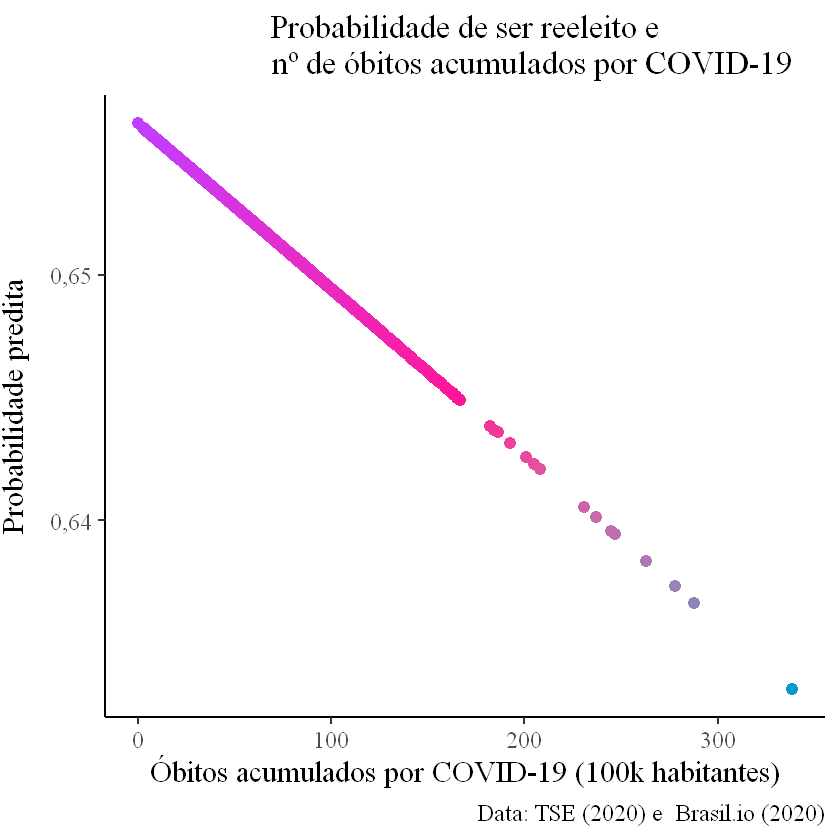

In [61]:
ggplot(base, aes(x = `Óbitos Acumulados`, y = PRED, colour = PRED)) +
  geom_point(size = 3) +
  scale_colour_gradientn(colours = c("deepskyblue3",
         "deeppink", "darkorchid1")) +
  labs(x = "Óbitos acumulados por COVID-19 (100k habitantes)", 
        y = "Probabilidade predita",
       title = "Probabilidade de ser reeleito e
                 nº de óbitos acumulados por COVID-19",
       caption = "Data: TSE (2020) e  Brasil.io (2020)") +
  theme_classic(base_family = "Times New Roman", base_size = 18) +
  theme(legend.position = "none",
        axis.title.y = element_text(vjust = 3),
        plot.title = element_text(family = "Times New Roman",
                    size = (20), hjust = 0.5))
